# Purpose
The purpose of this notebook is to test our simulators and emulators accuracy with the exact phase shifts from a Gaussian separable potential.

# Notebook Setup

## Importing Python libraries

In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
%load_ext autoreload    
%autoreload 2

sys.path.insert(0, '../../')

## Importing local libraries

In [2]:
from emulate_kvp import BuildMesh
from emulate_kvp import KVP_emulator
from emulate_kvp import LHS_setup
from emulate_kvp.utils import compute_mixed_S
from emulate_kvp.utils import fix_phases_continuity

from two_body_system import TwoBodyScattering
from separable_pot import SeparablePotential

## Parameters

In [3]:
### MESH INPUT PARAMETERS ###
ki = 0 # Mesh initial point
cut_reg1 = 3 # Mesh cutoff of first region
cut_reg2 = 6 # Mesh cutoff of second region
kf = 8 # Mesh cutoff

pts_reg1 = 40 # Total points in first region
pts_reg2 = 20 # Total points in second region
pts_reg3 = 20 # Total points in third region
Ntot = pts_reg1 + pts_reg2 + pts_reg3 # Total mesh size

mesh_nodes = [ki, cut_reg1, cut_reg2, kf]
pts_per_region = [pts_reg1, pts_reg2, pts_reg3]
mesh = BuildMesh(mesh_nodes, pts_per_region)
nodes, weights = mesh.nodes, mesh.weights

### SEPARABLE POTENTIAL PARAMETERS ###
BE = 2
lam2 = 200
lam_str_pred = -1.4401134464805077

## Phase shifts calculation

In [4]:
E_MeV = np.arange(1, 351)
simulator = TwoBodyScattering(E_MeV, nodes, weights)
E_tot, k_cm = simulator.E_tot, simulator.k

In [5]:
pot_pred = SeparablePotential(lam_str_pred, lam2, BE)
V_sep = pot_pred.get_sep_pot(nodes)

V_sep_w_k0 = np.zeros((len(k_cm), V_sep.shape[0] + 1, V_sep.shape[0] + 1))

for i, k0 in enumerate(k_cm):
    V_sep_w_k0[i] = pot_pred.get_sep_pot(np.append(nodes, k0))

In [6]:
phase_exact = np.degrees((np.log(pot_pred.analytical_S_mat(E_tot)) / 2j).real)
phase_exact = fix_phases_continuity(phase_exact, is_radians=False)

phase_std = simulator.phase_shifts(V_sep, use_glockle=False)
phase_glockle = simulator.phase_shifts(V_sep, use_glockle=True)
phase_no_interp = simulator.phase_shifts(V_sep_w_k0, use_glockle=None)

## Compute errors

In [7]:
rel_err_exact_std = abs((phase_exact - phase_std) / phase_exact)
rel_err_exact_glockle = abs((phase_exact - phase_glockle) / phase_exact)
rel_err_std_glockle = abs((phase_std - phase_glockle) / phase_std)
rel_err_exact_no_interp = abs((phase_exact - phase_no_interp) / phase_exact)
rel_err_no_interp_glockle = abs((phase_no_interp - phase_glockle) / phase_no_interp)
rel_err_no_interp_std = abs((phase_no_interp - phase_std) / phase_no_interp)

## Plots
### Exact vs. simulators

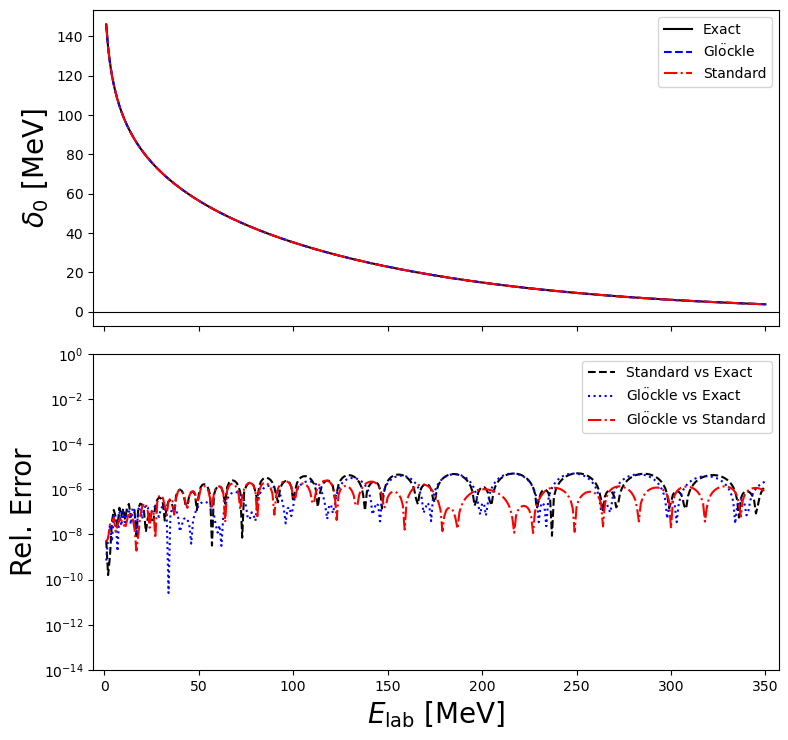

In [8]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 7.5), sharex=True)
zero_kwargs = dict(c='black', lw=0.8, zorder=0)

ax1.axhline(0, 0, 1, **zero_kwargs)
ax1.plot(E_MeV, phase_exact, ls='solid', c='k', label='Exact')
ax1.plot(E_MeV, phase_glockle, ls='dashed', c='b', label=r'Gl$\mathrm{\ddot{o}}$ckle')
ax1.plot(E_MeV, phase_std, ls='dashdot', c='r', label='Standard')
ax1.set_xlim(E_MeV[0] - 7, E_MeV[-1] + 7)
ax1.set_ylabel(r'$\delta_0$ [MeV]', fontsize=20)
ax1.legend()

ax2.semilogy(E_MeV, rel_err_exact_glockle, lw=1.5, c='k', 
             ls='dashed', label='Standard vs Exact')
ax2.semilogy(E_MeV, rel_err_exact_std, lw=1.5, c='b', 
             ls='dotted', label=r'Gl$\mathrm{\ddot{o}}$ckle vs Exact')
ax2.semilogy(E_MeV, rel_err_std_glockle, lw=1.5, c='r', 
             ls='dashdot', label=r'Gl$\mathrm{\ddot{o}}$ckle vs Standard')

ax2.set_xlabel("$E_{\mathrm{lab}}$ [MeV]", fontsize=20)
ax2.set_xlim(E_MeV[0] - 7, E_MeV[-1] + 7)
ax2.set_ylim(1e-14, 1e0)
ax2.set_ylabel(r'Rel. Error', fontsize=20)
ax2.legend(loc='best')

fig.set_constrained_layout_pads(w_pad=0.02, h_pad=0.02, hspace=0, wspace=0)
fig.tight_layout()

### No interpolation vs. exact/simulators

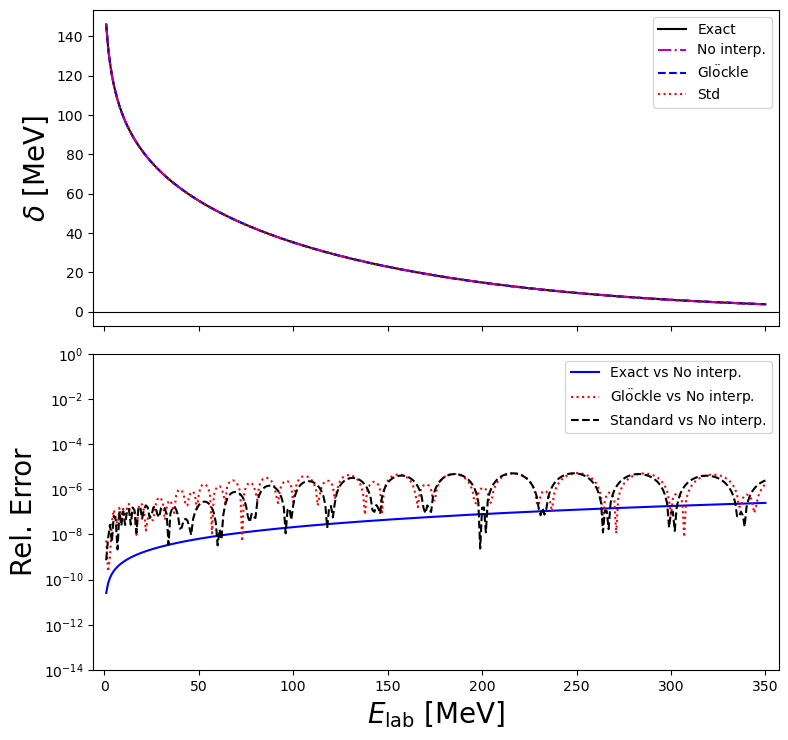

In [15]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 7.5), sharex=True)
zero_kwargs = dict(c='black', lw=0.8, zorder=0)

ax1.axhline(0, 0, 1, **zero_kwargs)
ax1.plot(E_MeV, phase_exact, c='k', ls='solid', label='Exact')
ax1.plot(E_MeV, phase_no_interp, ls='dashdot', c='m', label='No interp.')
ax1.plot(E_MeV, phase_glockle, ls='dashed', c='b', label=r'Gl$\mathrm{\ddot{o}}$ckle')
ax1.plot(E_MeV, phase_std, ls='dotted', c='r', label='Std')

ax1.set_xlim(E_MeV[0] - 7, E_MeV[-1] + 7)
ax1.set_ylabel(r'$\delta$ [MeV]', fontsize=20)
ax1.legend()

ax2.semilogy(E_MeV, rel_err_exact_no_interp, lw=1.5, c='b', 
             ls='solid', label='Exact vs No interp.')
ax2.semilogy(E_MeV, rel_err_no_interp_glockle, lw=1.5, c='r', 
             ls='dotted', label=r'Gl$\mathrm{\ddot{o}}$ckle vs No interp.')
ax2.semilogy(E_MeV, rel_err_no_interp_std, lw=1.5, c='k', 
             ls='dashed', label='Standard vs No interp.')

ax2.set_xlabel("$E_{\mathrm{lab}}$ [MeV]", fontsize=20)
ax2.set_xlim(E_MeV[0] - 7, E_MeV[-1] + 7)
ax2.set_ylim(1e-14, 1e0)
ax2.set_ylabel(r'Rel. Error', fontsize=20)
ax2.legend(loc='best')

fig.set_constrained_layout_pads(w_pad=0.02, h_pad=0.02, hspace=0, wspace=0)
fig.tight_layout()

## Emulator calculation

In [10]:
wave = 'None'
solver = 'lstsq'
emu_method = 'all'
nugget = 1e-10

In [11]:
params_valid = np.array([lam_str_pred])
params_train = np.array([[-5], [-10], [-0.5], [1]])

delta_b = np.zeros((params_train.shape[0], len(E_MeV)))
V1 = (V_sep_w_k0 / lam_str_pred)[:, :, :, None]
V0 = np.zeros((V1.shape[0], V1.shape[1], V1.shape[2]))

for i, lec_i in enumerate(params_train):
    pot = SeparablePotential(lec_i, lam2, BE)
    delta_b[i] = np.degrees((np.log(pot.analytical_S_mat(E_tot)) / 2j).real)

In [12]:
emulator = KVP_emulator(k_cm, nodes, weights, V0, 
                        V1, wave, is_coupled=False)
emulator.train(params_train, glockle=True, method=emu_method)
tau_emu_glockle = emulator.prediction(params_valid, glockle=True, 
                                      sol=solver, h=nugget)

emulator.train(params_train, glockle=False, method=emu_method)
tau_emu_std = emulator.prediction(params_valid, glockle=False, 
                                  sol=solver, h=nugget)

tau_emu_glockle_mix = compute_mixed_S(tau_emu_glockle)
phase_emu_glockle = np.arctan(tau_emu_glockle_mix) * 180 / np.pi
phase_emu_glockle = fix_phases_continuity(phase_emu_glockle, is_radians=False)

tau_emu_std_mix = compute_mixed_S(tau_emu_std)
phase_emu_std = np.arctan(tau_emu_std_mix) * 180 / np.pi
phase_emu_std = fix_phases_continuity(phase_emu_std, is_radians=False)

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


## Phase shifts: Exact vs. Emulators

In [13]:
rel_glockle_emu_exact = abs((phase_exact - phase_emu_glockle) / phase_exact)
rel_std_emu_exact = abs((phase_exact - phase_emu_std) / phase_exact)
rel_std_glockle_emu = abs((phase_emu_std - phase_emu_glockle) / phase_emu_std)

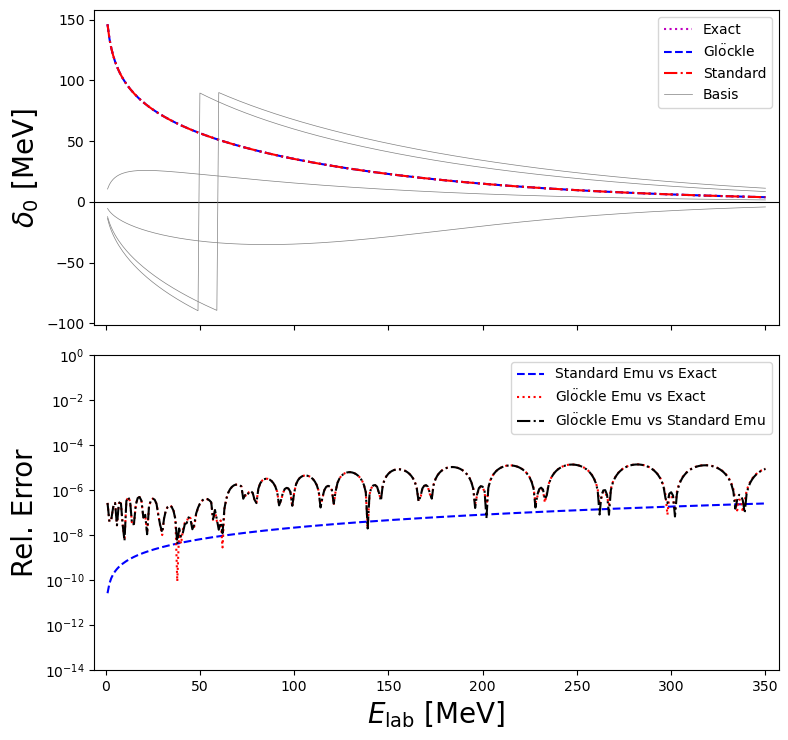

In [16]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 7.5), sharex=True)
zero_kwargs = dict(c='black', lw=0.8, zorder=0)

ax1.axhline(0, 0, 1, **zero_kwargs)
ax1.plot(E_MeV, phase_exact, ls='dotted', c='m', label='Exact')
ax1.plot(E_MeV, phase_emu_glockle, ls='dashed', c='b', label=r'Gl$\mathrm{\ddot{o}}$ckle')
ax1.plot(E_MeV, phase_emu_std, ls='dashdot', c='r', label='Standard')

for delta_i in delta_b:
    ax1.plot(E_MeV, delta_i, c='grey', lw=0.5)

ax1.plot([], [], c='grey', lw=0.5, label='Basis')
ax1.set_xlim(E_MeV[0] - 7, E_MeV[-1] + 7)
ax1.set_ylabel(r'$\delta_0$ [MeV]', fontsize=20)
ax1.legend()

ax2.semilogy(E_MeV, rel_std_emu_exact, lw=1.5, c='b', 
             ls='dashed', label='Standard Emu vs Exact')
ax2.semilogy(E_MeV, rel_glockle_emu_exact, lw=1.5, c='r', 
             ls='dotted', label=r'Gl$\mathrm{\ddot{o}}$ckle Emu vs Exact')
ax2.semilogy(E_MeV, rel_std_glockle_emu, lw=1.5, 
             c='k', ls='dashdot', label=r'Gl$\mathrm{\ddot{o}}$ckle Emu vs Standard Emu')

ax2.set_xlabel("$E_{\mathrm{lab}}$ [MeV]", fontsize=20)
ax2.set_xlim(E_MeV[0] - 7, E_MeV[-1] + 7)
ax2.set_ylim(1e-14, 1e0)
ax2.set_ylabel(r'Rel. Error', fontsize=20)
ax2.legend(loc='best')

fig.set_constrained_layout_pads(w_pad=0.02, h_pad=0.02, hspace=0, wspace=0)
fig.tight_layout()